<a href="https://colab.research.google.com/github/anphantt2406/Time-series-analysis/blob/main/%5BML2020%5D_TimeSeries_PhanThiThuyAn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np                              
import pandas as pd                              
import matplotlib.pyplot as plt   
%matplotlib inline               
import seaborn as sns                           
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import datetime as dt
import calendar

%matplotlib inline

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/anphantt2406/Time-series-analysis/main/CADairyProduction.csv')
data.columns = ['Year',	'Month',	'Cotagecheese_Prod', 'Icecream_Prod',	'Milk_Prod',	'N.CA.Fat.Price',	'Month_Count',	'monthNumSquared','monthNumCubed']

data.loc[data['Month'] == 'Jan', 'Month'] = 1
data.loc[data['Month'] == 'Feb', 'Month'] = 2
data.loc[data['Month'] == 'Mar', 'Month'] = 3
data.loc[data['Month'] == 'Apr', 'Month'] = 4
data.loc[data['Month'] == 'May', 'Month'] = 5
data.loc[data['Month'] == 'Jun', 'Month'] = 6
data.loc[data['Month'] == 'Jul', 'Month'] = 7
data.loc[data['Month'] == 'Aug', 'Month'] = 8
data.loc[data['Month'] == 'Sep', 'Month'] = 9
data.loc[data['Month'] == 'Oct', 'Month'] = 10
data.loc[data['Month'] == 'Nov', 'Month'] = 11
data.loc[data['Month'] == 'Dec', 'Month'] = 12

data['Time'] = data['Year'].astype(str) +'-' + data['Month'].astype(str) 
data['Date']= pd.to_datetime(data['Time'], format='%Y-%m')
data

,Year,Month,Cotagecheese_Prod,Icecream_Prod,Milk_Prod,N.CA.Fat.Price,Month_Count,monthNumSquared,monthNumCubed,Time,Date
0,1995,1,4.370,51.595,2.112,0.9803,1,1,1,1995-1,1995-01-01
1,1995,2,3.695,56.086,1.932,0.8924,2,4,8,1995-2,1995-02-01
2,1995,3,4.538,68.453,2.162,0.8924,3,9,27,1995-3,1995-03-01
3,1995,4,4.280,65.722,2.130,0.8967,4,16,64,1995-4,1995-04-01
4,1995,5,4.470,73.730,2.227,0.8967,5,25,125,1995-5,1995-05-01
...,...,...,...,...,...,...,...,...,...,...,...
223,2013,8,2.169,78.382,3.400,1.6273,224,50176,11239424,2013-8,2013-08-01
224,2013,9,2.193,74.871,3.197,1.5519,225,50625,11390625,2013-9,2013-09-01
225,2013,10,2.284,70.011,3.338,1.5566,226,51076,11543176,2013-10,2013-10-01
226,2013,11,1.865,61.394,3.275,1.7537,227,51529,11697083,2013-11,2013-11-01


In [ ]:
new_data = data[['Date', 'Milk_Prod']]
new_data.set_index('Date', inplace=True)
new_data

,Milk_Prod
Date,
1995-01-01,2.112
1995-02-01,1.932
1995-03-01,2.162
1995-04-01,2.130
1995-05-01,2.227
...,...
2013-08-01,3.400
2013-09-01,3.197
2013-10-01,3.338


# Question 1

Plot timeseries data

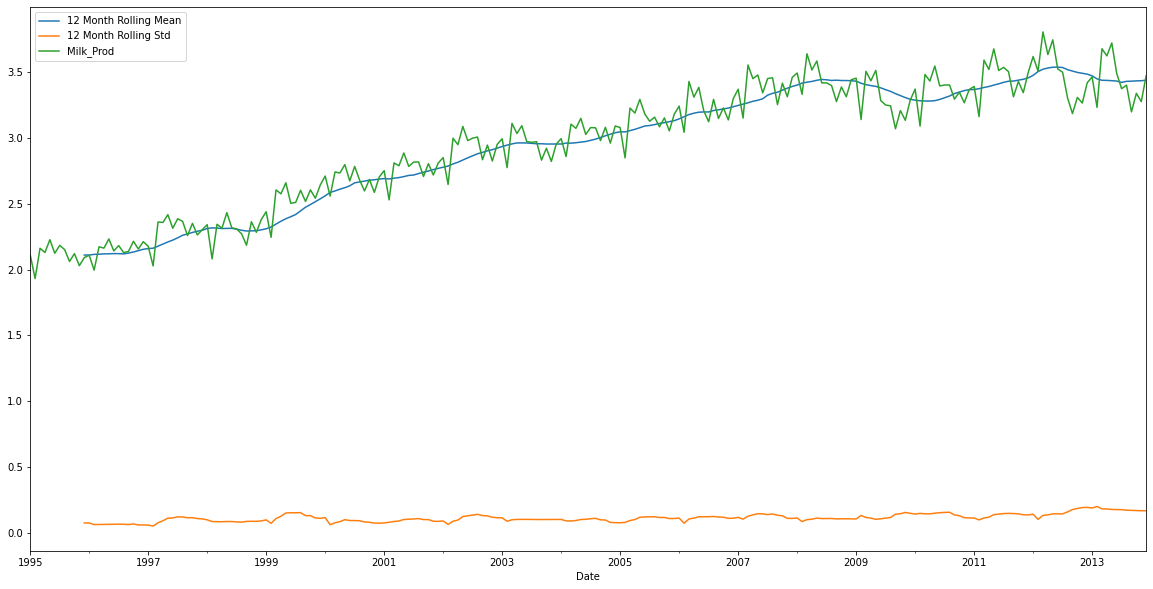

In [ ]:
plt.figure(figsize=(20,10))
time_series = new_data['Milk_Prod']
time_series.rolling(12).mean().plot(label='12 Month Rolling Mean')
time_series.rolling(12).std().plot(label='12 Month Rolling Std')
time_series.plot()
plt.legend()

<Figure size 432x288 with 0 Axes>

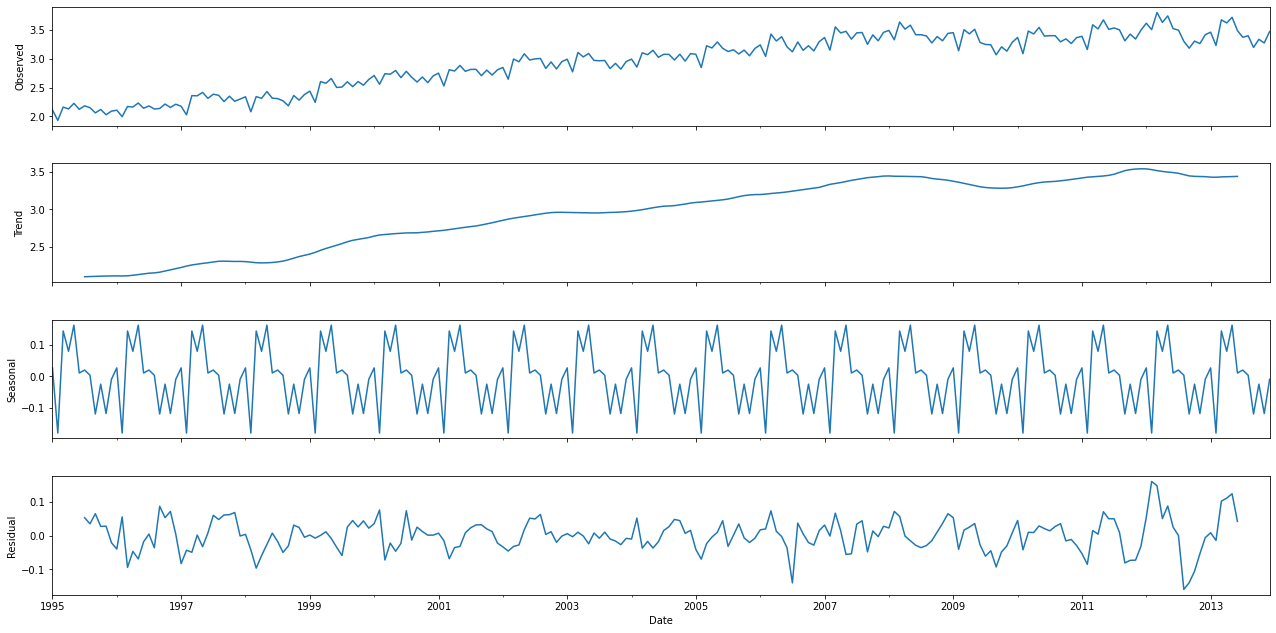

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(time_series, model='additive')

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(20,10)

# Question 2

Use Dickey-Fuller Test provided in ***statsmodels.tsa.stattools.adfuller*** to test whether this timeseries is stationary. 

In [ ]:
from statsmodels.tsa.stattools import adfuller
def check_adf(dataframe):
  result = adfuller(dataframe, autolag = 'AIC')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print("Number Of Lags : ", result[2])
  print("Num Of Observations Used For ADF Regression and Critical Values Calculation :", result[3])
  print('Critical Values:')
  for key, value in result[4].items():
	  print('\t%s: %.3f' % (key, value))
  if result[0] > result[4]["5%"]:
    print("Failed to Reject Ho - Time Series is Non-Stationary")
  else:
    print("Reject Ho - Time Series is Stationary")

In [ ]:
check_adf(new_data['Milk_Prod'])

ADF Statistic: -1.882423
p-value: 0.340374
Number Of Lags :  12
Num Of Observations Used For ADF Regression and Critical Values Calculation : 215
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Failed to Reject Ho - Time Series is Non-Stationary


# Question 3

Try to find the right order of differencing operator to make timeseries stationary. Use Dicky-Fuller test check stationary of transformed timeseries. The order of differencing will be d parameter of ARIMA model.

ADF Statistic: -3.932668
p-value: 0.001807
Number Of Lags :  11
Num Of Observations Used For ADF Regression and Critical Values Calculation : 215
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Reject Ho - Time Series is Stationary


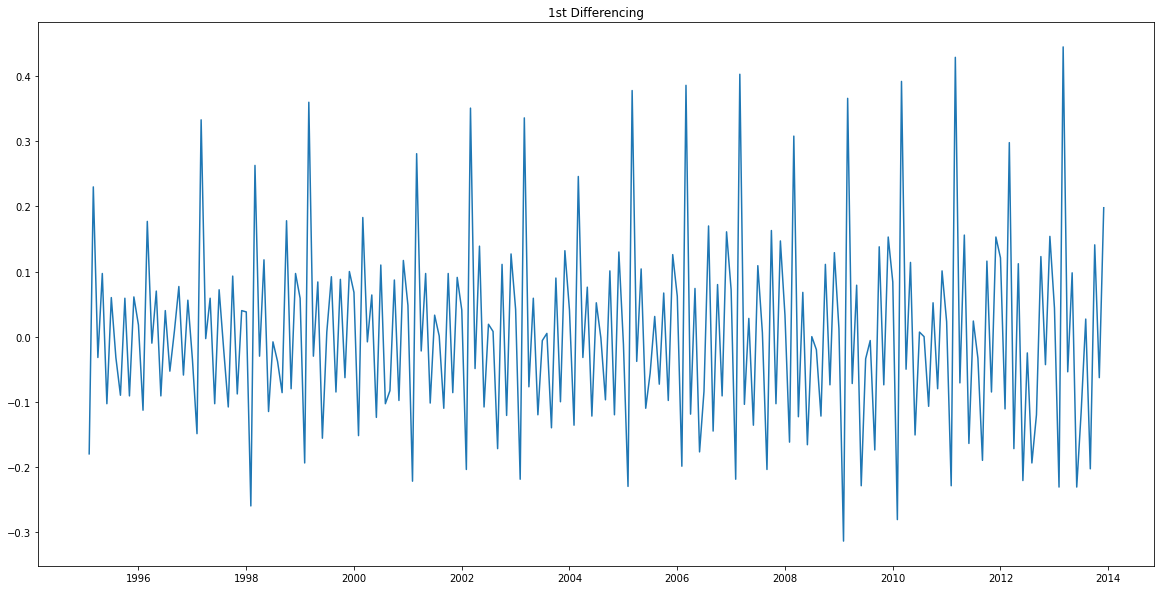

In [ ]:
dif1 = time_series.diff().dropna()
check_adf(dif1)

transformed_data = pd.DataFrame(new_data['Milk_Prod'].diff().dropna())
plt.figure(figsize=(20,10))
plt.plot(dif1)
plt.title('1st Differencing')
plt.show()

**The number of differencing required to make the time series stationary is 1**. 

$d = 1$

# Question 4

Plot ACF and PACF of transformed timeseries. Try to find (p, q, d) of ARIMA model and fitting model using statsmodels.tsa.arima.model.ARIMA. Predict milk production in 2015 and compute MAE in that period.

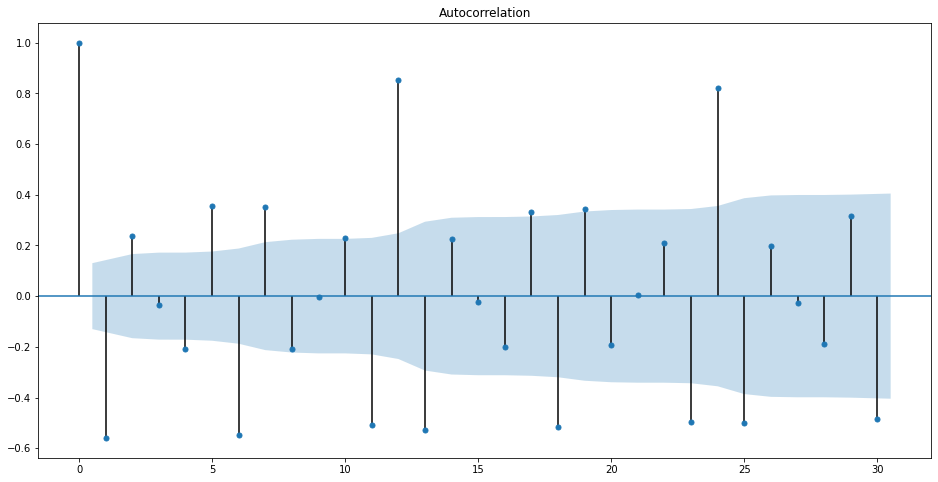

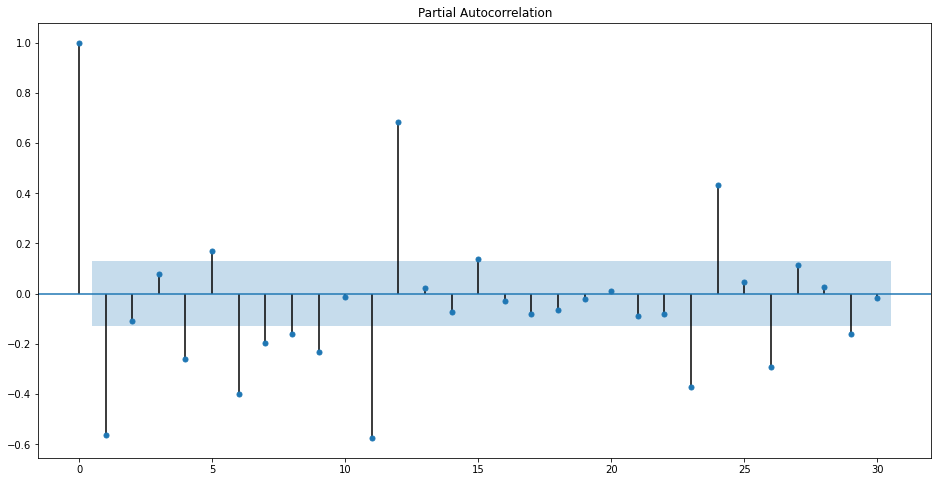

In [ ]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rc("figure", figsize=(16,8))
plot_acf(transformed_data['Milk_Prod'], lags = 30)
plot_pacf(transformed_data['Milk_Prod'], lags = 30)
plt.show()

**"Identification of an AR model is often best done with
the PACF"**. So, to estimate the amount of AR terms, you need to look at the PACF plot. We have p = 1

**"Identification of an MA model is often best done with the
ACF rather than the PACF"**. So, to estimate the amount of MA terms we will look at ACF plot. We have q = 2

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D2.Milk_Prod   No. Observations:                  226
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 154.164
Method:                       css-mle   S.D. of innovations              0.121
Date:                Tue, 01 Dec 2020   AIC                           -300.328
Time:                        13:56:02   BIC                           -286.646
Sample:                    03-01-1995   HQIC                          -294.806
                         - 12-01-2013                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -5.258e-05   7.84e-05     -0.671      0.503      -0.000       0.000
ar.L1.D2.Milk_Prod    -0.5650      0.055    -10.252      0.000      -0.673      -0.457
ma.L1.D2.Milk_Prod  

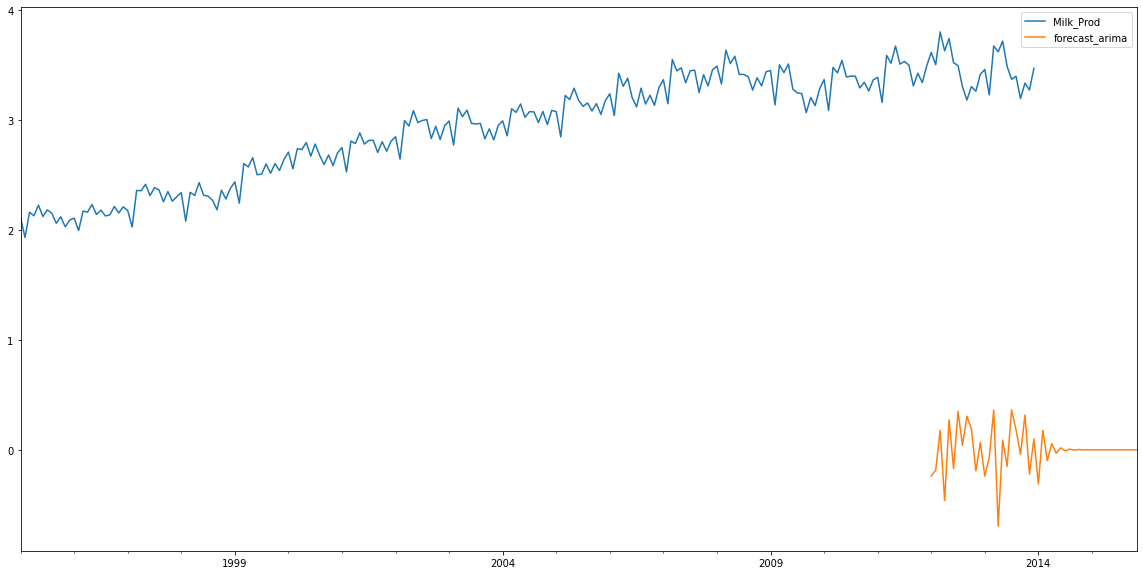

In [ ]:
from pandas.tseries.offsets import DateOffset

#(p, q, d) of ARIMA
order = (1, 2, 1)
model = ARIMA(time_series, order)
model_fit = model.fit()
print(model_fit.summary())

future_dates_ari = [new_data.index[-1] + DateOffset(months=x) for x in range(1,24)]
future_data_ari = pd.DataFrame(index=future_dates_ari,columns=new_data.columns)

arima_data = pd.concat([new_data,future_data_ari])

arima_data['forecast_arima'] = model_fit.predict(start='2012-01-01', end='2015-12-01')
arima_data[['Milk_Prod','forecast_arima']].plot(figsize=(20,10))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


ADF Statistic: -3.128691
p-value: 0.024502
Number Of Lags :  13
Num Of Observations Used For ADF Regression and Critical Values Calculation : 202
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Reject Ho - Time Series is Stationary


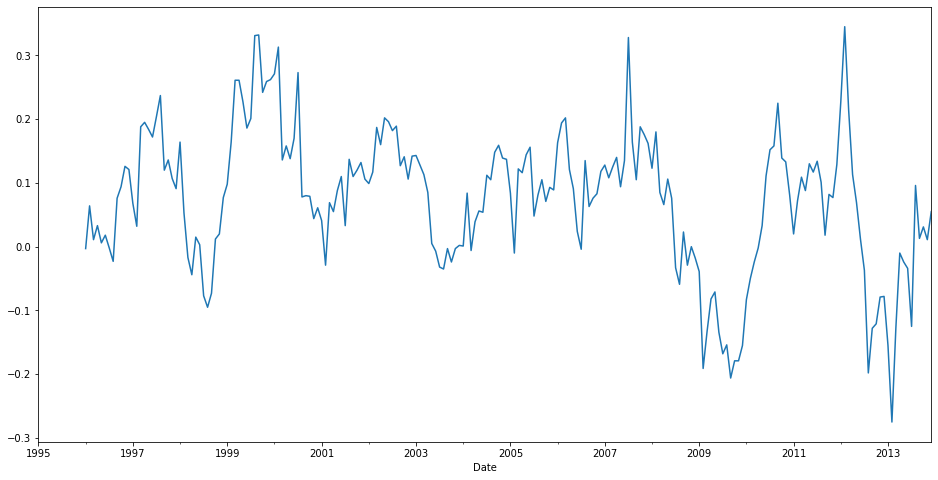

In [ ]:
new_data['Seasonal Difference'] = new_data['Milk_Prod'].diff(12)
new_data['Seasonal Difference'].plot()

check_adf(new_data['Seasonal Difference'].dropna())

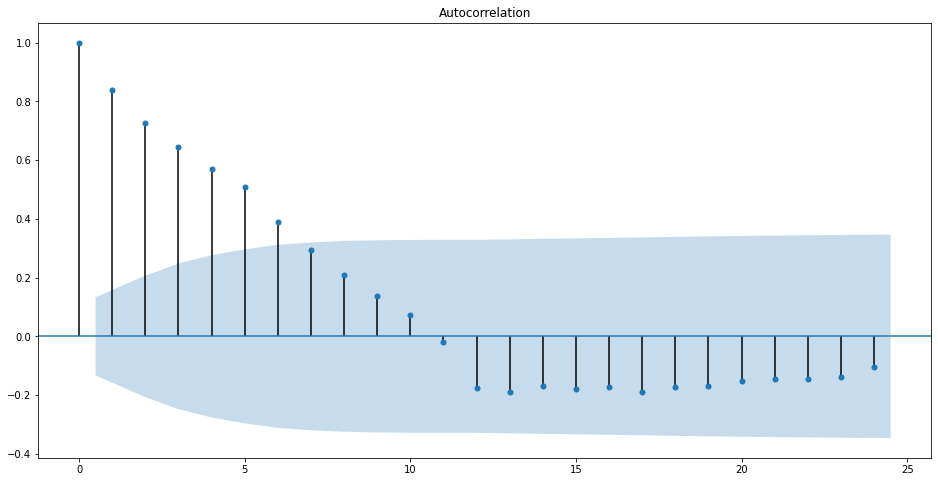

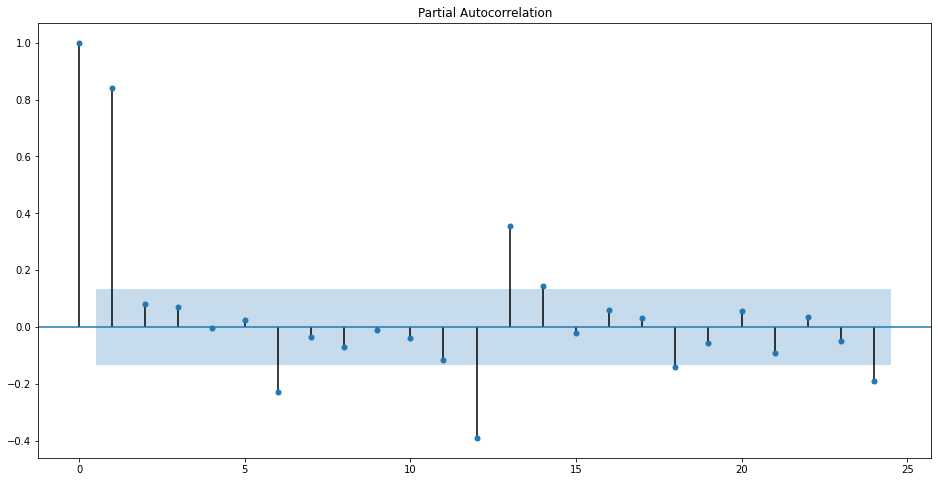

In [ ]:
plot_acf(new_data['Seasonal Difference'].dropna());
plot_pacf(new_data['Seasonal Difference'].dropna());

In [ ]:
model_sari = sm.tsa.statespace.SARIMAX(new_data['Milk_Prod'],order = (1,2,1),seasonal_order=(6,0,1,12))
results_sari = model_sari.fit()
print(results_sari.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                          Milk_Prod   No. Observations:                  228
Model:             SARIMAX(1, 2, 1)x(6, 0, 1, 12)   Log Likelihood                 351.614
Date:                            Tue, 01 Dec 2020   AIC                           -683.229
Time:                                    13:56:48   BIC                           -649.024
Sample:                                01-01-1995   HQIC                          -669.425
                                     - 12-01-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0499      0.083     -0.602      0.547      -0.213       0.113
ma.L1         -0.9513      0.038   

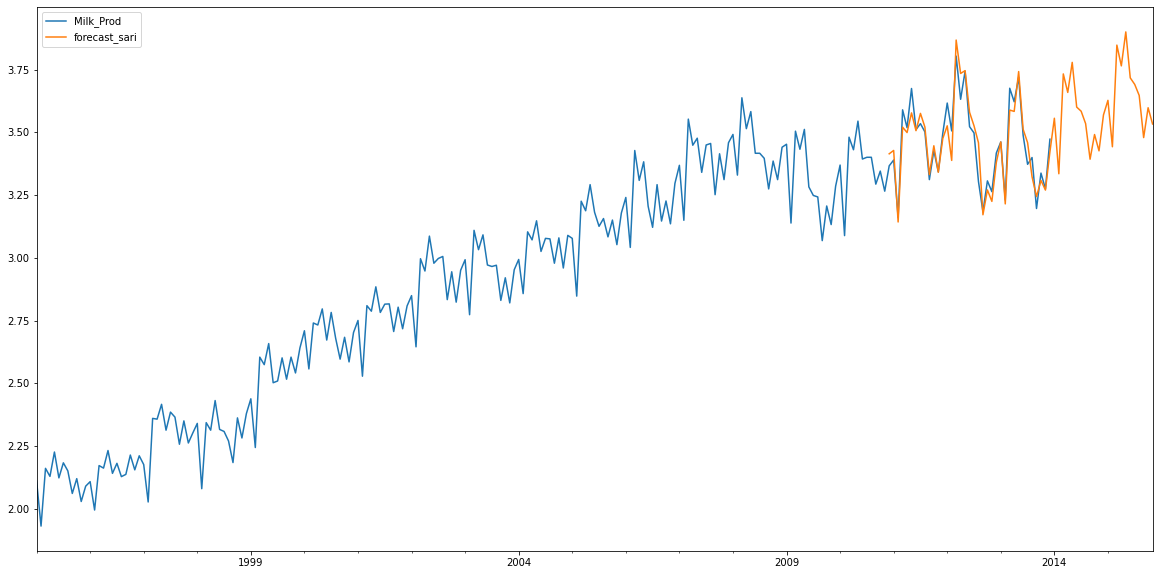

In [ ]:
future_dates = [new_data.index[-1] + DateOffset(months=x) for x in range(1,24)]
future_data_sari = pd.DataFrame(index=future_dates,columns=new_data.columns)

sari_data = pd.concat([new_data,future_data_sari])
sari_data['forecast_sari'] = results_sari.predict(start='2010-12-01', end='2015-12-01')
sari_data[['Milk_Prod','forecast_sari']].plot(figsize=(20,10))